In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.autograd import Variable, grad

# Set random seed for reproducibility
manualSeed = random.randint(1, 10000)
manualSeed = 999
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Define parameters
# Root directory for dataset
dataroot = "data/"

# Number of workers for dataloader
workers = 2

batch_size = 50
image_size = 28
image_channels = 1
noise_dim = 128
feature_dim = 64
num_epochs = 10
OUTPUT_DIM = 784
CRITIC_ITERS = 1 #5 did not yield good results
lambda_gp = 10
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1
num_classes = 10

# Set the mode (dcgan, wgan, wgan-gp)
mode = 'dcgan'

100%|██████████| 26421880/26421880 [00:02<00:00, 10543885.92it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 167300.56it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:03<00:00, 1396254.23it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 16660707.56it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



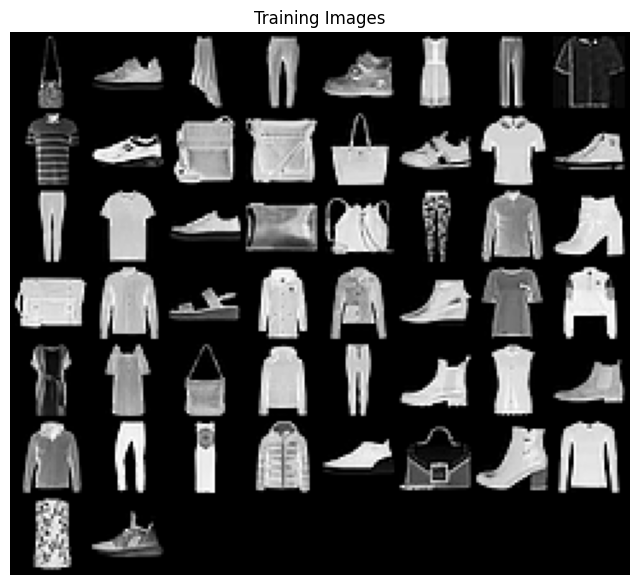

In [3]:
# Create the dataset
dataset = FashionMNIST(root=dataroot,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,), (0.5,)),
                       ]),
                       download=True)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
# Display the images
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.show()

In [4]:
import torch.nn.functional as F
class ScaledShiftedSoftplus(nn.Module):
    def forward(self, x):
        return F.softplus(2 * x + 2) / 2 - 1

In [10]:
class Generator1(nn.Module):
    def __init__(self, noise_dim, num_classes, image_channels, feature_dim, mode):
        super(Generator1, self).__init__()
        self.mode = mode
        self.model = nn.Sequential(
            # Fully connected layer
            nn.Linear(noise_dim + num_classes, 4 * 4 * 4 * feature_dim),
            # Batch normalization after the linear layer
            nn.BatchNorm1d(4 * 4 * 4 * feature_dim),

            # Reshape layer
            nn.Unflatten(1, (4 * feature_dim, 4, 4)),

            # First deconv layer (upsampling to 8x8)
            nn.ConvTranspose2d(4 * feature_dim, 2 * feature_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2 * feature_dim),
            nn.ReLU(inplace=True),

            # Second deconv layer (upsampling to 16x16)
            nn.ConvTranspose2d(2 * feature_dim, feature_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_dim),
            nn.ReLU(inplace=True),

            # Final deconv layer (upsampling to 28x28)
            nn.ConvTranspose2d(feature_dim, image_channels, kernel_size=4, stride=2, padding=3),
            nn.Tanh()  # Output should be in the range [-1, 1]
        )

    def forward(self, noise, class_labels):
        # Concatenate noise with class labels
        input = torch.cat((noise, class_labels), dim=1)  # Concatenate along the feature dimension
        return self.model(input)


class Generator2(nn.Module):
    def __init__(self, noise_dim, num_classes, image_channels, feature_dim, mode):
        super(Generator2, self).__init__()
        self.mode = mode
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 4 * 4 * 8 * feature_dim),
            nn.BatchNorm1d(4 * 4 * 8 * feature_dim),
            nn.Unflatten(1, (8 * feature_dim, 4, 4)),

            # First deconv layer (upsampling to 8x8)
            nn.ConvTranspose2d(8 * feature_dim, 4 * feature_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(4 * feature_dim),
            ScaledShiftedSoftplus(),

            # Second deconv layer (upsampling to 16x16)
            nn.ConvTranspose2d(4 * feature_dim, 2 * feature_dim, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(2 * feature_dim),
            ScaledShiftedSoftplus(),

            # Third deconv layer (keep at 16x16)
            nn.ConvTranspose2d(2 * feature_dim, feature_dim, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(feature_dim),
            ScaledShiftedSoftplus(),

            # Final deconv layer (upsampling to 28x28)
            nn.ConvTranspose2d(feature_dim, image_channels, kernel_size=4, stride=2, padding=3),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, noise, class_labels):
        input = torch.cat((noise, class_labels), dim=1)
        return self.model(input)


# Instantiate and test the generator
generator = Generator1(noise_dim, 10, image_channels, feature_dim, mode)
noise = torch.randn(batch_size, noise_dim)

# Temporarily generate random one-hot encoded vectors = batch_size
labels = torch.randint(0, num_classes, (batch_size,))
one_hot_labels = torch.nn.functional.one_hot(labels, num_classes=num_classes).float()

generated_images = generator(noise, one_hot_labels)
print(generated_images.shape)  # Expected output shape: (batch_size, image_channels, 28, 28)

torch.Size([50, 1, 28, 28])


In [11]:
class Discriminator1(nn.Module):
    def __init__(self, image_channels, num_classes, feature_dim, mode):
        super(Discriminator1, self).__init__()
        self.mode = mode
        self.model = nn.Sequential(
            # First conv layer
            nn.Conv2d(image_channels + num_classes, feature_dim, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),

            # Second conv layer
            nn.Conv2d(feature_dim, 2*feature_dim, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(2 * feature_dim) if mode == 'wgan' else nn.Identity(),
            nn.LeakyReLU(0.2, inplace=True),

            # Third conv layer
            nn.Conv2d(2*feature_dim, 4*feature_dim, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm2d(4 * feature_dim) if mode == 'wgan' else nn.Identity(),
            nn.LeakyReLU(0.2, inplace=True),

            # Final fully connected layer
            nn.Flatten(),
            nn.Linear(4*4*4*feature_dim, 1),
            nn.Sigmoid() if mode == 'dcgan' else nn.Identity()  # Output a single value between 0 and 1
        )

    def forward(self, x, class_labels):
        # Concatenate image with class labels (expand class_labels to match image dimensions)
        class_labels = class_labels.unsqueeze(2).unsqueeze(3)  # Add spatial dimensions
        class_labels = class_labels.expand(-1, -1, x.size(2), x.size(3))  # Broadcast to image dimensions
        input = torch.cat((x, class_labels), dim=1)  # Concatenate along the channel dimension

        output = self.model(input)
        return output


class Discriminator2(nn.Module):
    def __init__(self, image_channels, num_classes, feature_dim, mode):
        super(Discriminator2, self).__init__()
        self.mode = mode
        # Updated input dimension to include class labels
        self.model = nn.Sequential(
            # First conv layer
            nn.Conv2d(image_channels + num_classes, feature_dim, kernel_size=5, stride=2, padding=2),
            nn.LeakyReLU(0.2, inplace=True),

            # Second conv layer
            nn.Conv2d(feature_dim, 2 * feature_dim, kernel_size=5, stride=2, padding=2),
            nn.LayerNorm([2 * feature_dim, 7, 7]) if mode == 'wgan-gp' else nn.BatchNorm2d(2 * feature_dim),
            ScaledShiftedSoftplus(),

            # Third conv layer - downsample to [4, 4]
            nn.Conv2d(2 * feature_dim, 4 * feature_dim, kernel_size=5, stride=2, padding=2),
            nn.LayerNorm([4 * feature_dim, 4, 4]) if mode == 'wgan-gp' else nn.BatchNorm2d(4 * feature_dim),
            ScaledShiftedSoftplus(),

            # Fourth conv layer - maintain [4, 4] dimensions
            nn.Conv2d(4 * feature_dim, 8 * feature_dim, kernel_size=3, stride=1, padding=1),
            nn.LayerNorm([8 * feature_dim, 4, 4]) if mode == 'wgan-gp' else nn.BatchNorm2d(8 * feature_dim),
            ScaledShiftedSoftplus(),

            # Final fully connected layer
            nn.Flatten(),
            nn.Linear(4 * 4 * 8 * feature_dim, 1),  # Adjusted for concatenated class labels
            nn.Sigmoid() if mode == 'dcgan' else nn.Identity()
        )

    def forward(self, x, class_labels):
        # Concatenate image with class labels (expand class_labels to match image dimensions)
        class_labels = class_labels.unsqueeze(2).unsqueeze(3)  # Add spatial dimensions
        class_labels = class_labels.expand(-1, -1, x.size(2), x.size(3))  # Broadcast to image dimensions
        input = torch.cat((x, class_labels), dim=1)  # Concatenate along the channel dimension

        output = self.model(input)
        return output


# Example usage:
discriminator = Discriminator1(image_channels, num_classes, feature_dim, mode)
image_samples = torch.randn(batch_size, image_channels, 28, 28)

class_labels = torch.randint(0, num_classes, (batch_size,))
one_hot_labels = torch.nn.functional.one_hot(class_labels, num_classes=num_classes).float()

discriminator_output = discriminator(image_samples, one_hot_labels)
print(discriminator_output.shape)  # Expected output shape: (batch_size, 1)

torch.Size([50, 1])


In [7]:
# Create the samples directory if it does not exist
os.makedirs('samples', exist_ok=True)

# mode = ['dcgan', 'wgan', 'wgan-gp']

# Utility functions
def plot_losses(losses_dict, arch):
    # Averaging losses every 500 iterations
    interval = 500
    disc_losses_dcgan = average_losses(losses_dict['disc_losses_dcgan'], interval)
    gen_losses_dcgan = average_losses(losses_dict['gen_losses_dcgan'], interval)
    disc_losses_wgan = average_losses(losses_dict['disc_losses_wgan'], interval)
    gen_losses_wgan = average_losses(losses_dict['gen_losses_wgan'], interval)
    disc_losses_wgan_gp = average_losses(losses_dict['disc_losses_wgan_gp'], interval)
    gen_losses_wgan_gp = average_losses(losses_dict['gen_losses_wgan_gp'], interval)

    # Smoothing curves
    disc_losses_dcgan = smooth_curve(disc_losses_dcgan, factor=0.95)
    gen_losses_dcgan = smooth_curve(gen_losses_dcgan, factor=0.95)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(gen_losses_dcgan, label='Generator Loss (DCGAN)')
    plt.plot(gen_losses_wgan, label='Generator Loss (WGAN)')
    plt.plot(gen_losses_wgan_gp, label='Generator Loss (WGAN-GP)')
    plt.title(f'Generator Losses during Training Architecture {arch}')
    plt.xlabel('Averaged Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(disc_losses_dcgan, label='Discriminator Loss (DCGAN)')
    plt.plot(disc_losses_wgan, label='Discriminator Loss (WGAN)')
    plt.plot(disc_losses_wgan_gp, label='Discriminator Loss (WGAN-GP)')
    plt.title(f'Discriminator Losses during Training Architecture {arch}')
    plt.xlabel('Averaged Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f'losses_generator_discriminator_{arch}.png')
    plt.show()

def average_losses(losses, interval=100):
    return [sum(losses[i:i+interval]) / interval for i in range(0, len(losses), interval)]

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            smoothed_points.append(smoothed_points[-1] * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def calc_gradient_penalty(D, real_images, fake_images, labels, lambda_gp):
    batch_size, channels, height, width = real_images.shape
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)

    # Interpolate between real and fake images
    interpolated = epsilon * real_images + (1 - epsilon) * fake_images
    interpolated.requires_grad_(True)

    # Compute the discriminator output for interpolated images with labels
    d_interpolated = D(interpolated, labels)  # Pass labels along with interpolated images

    # Calculate gradients of outputs w.r.t. interpolated images
    gradients = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones(d_interpolated.size(), device=device),
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]

    # Reshape gradients to calculate the gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty


Mode: dcgan | Epoch [1/10] Batch 0/1200 Loss D: 1.5080, Loss G: 0.8232
Mode: dcgan | Epoch [1/10] Batch 600/1200 Loss D: 0.3606, Loss G: 3.2252
Mode: dcgan | Epoch [2/10] Batch 0/1200 Loss D: 0.7895, Loss G: 3.3261
Mode: dcgan | Epoch [2/10] Batch 600/1200 Loss D: 0.5225, Loss G: 3.7498
Mode: dcgan | Epoch [3/10] Batch 0/1200 Loss D: 0.8250, Loss G: 1.5814
Mode: dcgan | Epoch [3/10] Batch 600/1200 Loss D: 0.0849, Loss G: 3.0767
Mode: dcgan | Epoch [4/10] Batch 0/1200 Loss D: 0.1286, Loss G: 3.6543
Mode: dcgan | Epoch [4/10] Batch 600/1200 Loss D: 0.8569, Loss G: 1.4554
Mode: dcgan | Epoch [5/10] Batch 0/1200 Loss D: 0.4193, Loss G: 6.8081
Mode: dcgan | Epoch [5/10] Batch 600/1200 Loss D: 0.4788, Loss G: 6.5395
Mode: dcgan | Epoch [6/10] Batch 0/1200 Loss D: 0.0458, Loss G: 4.7801
Mode: dcgan | Epoch [6/10] Batch 600/1200 Loss D: 0.0980, Loss G: 3.6413
Mode: dcgan | Epoch [7/10] Batch 0/1200 Loss D: 0.1502, Loss G: 2.6749
Mode: dcgan | Epoch [7/10] Batch 600/1200 Loss D: 0.1077, Loss G:

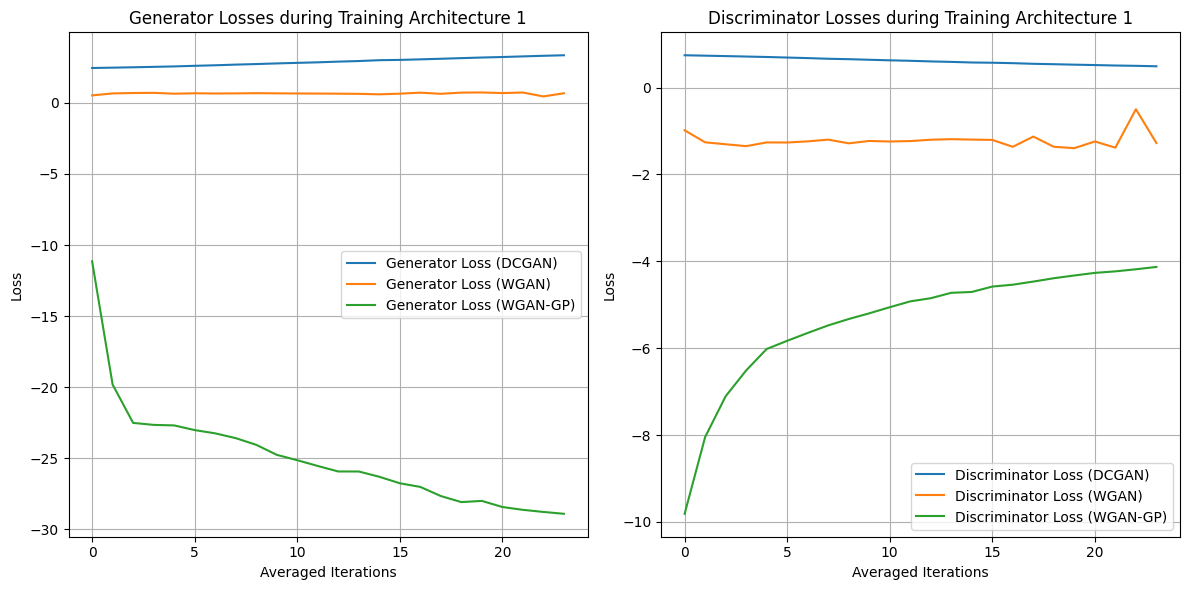

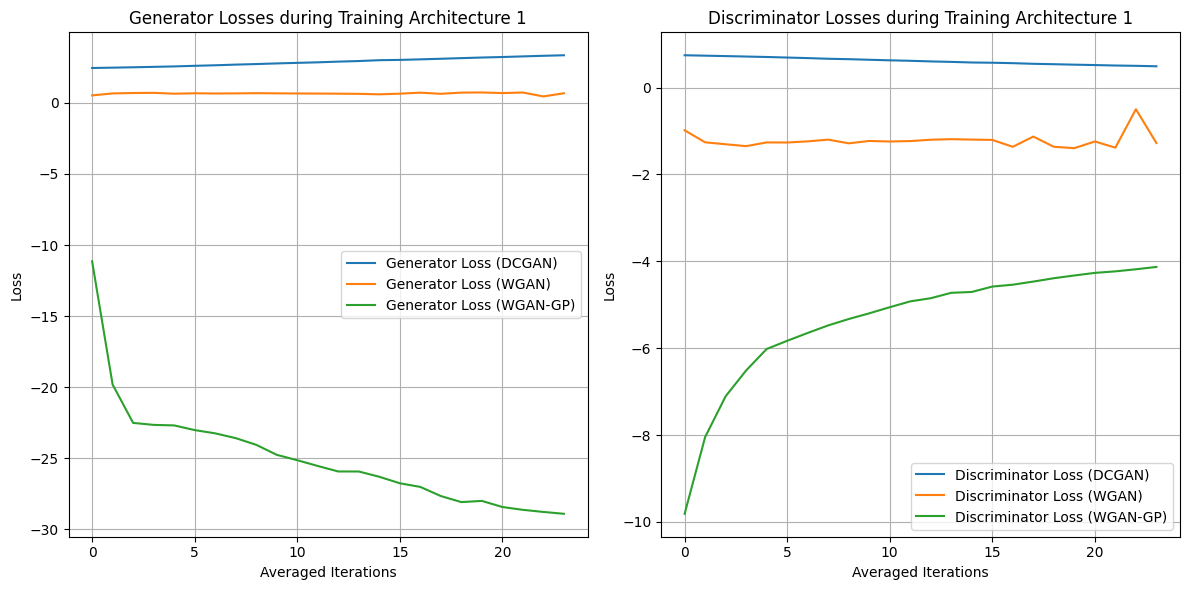

Training completed.
Training completed.


In [17]:
# Set modes
modes = ['dcgan', 'wgan', 'wgan-gp']
# modes = ['dcgan']
num_epochs = 10  # Adjust as needed
num_architectures = 2  # Number of architectures (Generator and Discriminator)
generators = [Generator1, Generator2]
discriminators = [Discriminator1, Discriminator2]

losses_dict = {
    'disc_losses_dcgan': [],
    'gen_losses_dcgan': [],
    'disc_losses_wgan': [],
    'gen_losses_wgan': [],
    'disc_losses_wgan_gp': [],
    'gen_losses_wgan_gp': []
}


CRITIC_ITERS = 5  # Number of iterations for WGAN and WGAN-GP

# for arch in range(num_architectures):
arch = 1

for mode in modes:
    # Initialize models
    G = generators[arch](noise_dim, num_classes, image_channels, feature_dim, mode).to(device)
    D = discriminators[arch](image_channels, num_classes, feature_dim, mode).to(device)

    # Loss function
    if mode == 'dcgan':
      criterion = nn.BCELoss()
    else:
        criterion = None

    # Optimizers
    if mode == 'dcgan':
        optimizer_G = optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
        if arch == 1:
            optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=1e-3)
        else:
            optimizer_D = optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))
    elif mode == 'wgan':
        optimizer_G = optim.RMSprop(G.parameters(), lr=5e-5)
        if arch == 1:
            optimizer_D = optim.Adam(D.parameters(), lr=5e-5, weight_decay=1e-3)
        else:
            optimizer_D = optim.RMSprop(D.parameters(), lr=5e-5)
    else:  # wgan-gp
        optimizer_G = optim.Adam(G.parameters(), lr=1e-4, betas=(0.5, 0.9))
        if arch == 1:
            optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9), weight_decay=1e-3)
        else:
            optimizer_D = optim.Adam(D.parameters(), lr=1e-4, betas=(0.5, 0.9))

    # Noise for sampling
    fixed_noise = torch.randn(64, noise_dim, device=device)
    class_labels_fixed = torch.randint(0, num_classes, (64,), device=device)
    one_hot_fixed = torch.nn.functional.one_hot(class_labels_fixed, num_classes=num_classes).float()

    # Training loop
    for epoch in range(num_epochs):
        # Set the number of discriminator iterations based on mode
        disc_iters = 1 if mode == 'dcgan' else CRITIC_ITERS

        for batch_idx, (real_images, class_labels) in enumerate(dataloader):
            # Prepare data
            real_images = real_images.to(device)
            class_labels = class_labels.to(device)
            one_hot_labels = torch.nn.functional.one_hot(class_labels, num_classes=num_classes).float()
            batch_size = real_images.size(0)
            real_labels = torch.ones(batch_size, device=device)
            fake_labels = torch.zeros(batch_size, device=device)

            # =======================
            # Train Discriminator
            # =======================
            for _ in range(disc_iters):
                D.zero_grad()
                # Loss on real images
                outputs = D(real_images, one_hot_labels).view(-1)
                d_loss_real = criterion(outputs, real_labels) if mode == 'dcgan' else -torch.mean(outputs)
                d_loss_real.backward()

                # Loss on fake images
                noise = torch.randn(batch_size, noise_dim, device=device)
                fake_images = G(noise, one_hot_labels)
                outputs = D(fake_images.detach(), one_hot_labels).view(-1)
                d_loss_fake = criterion(outputs, fake_labels) if mode == 'dcgan' else torch.mean(outputs)
                d_loss_fake.backward()

                if mode == 'wgan-gp':
                    gradient_penalty = calc_gradient_penalty(D, real_images, fake_images, one_hot_labels, lambda_gp)
                    gradient_penalty.backward()

                # Update discriminator
                optimizer_D.step()

                if mode == 'wgan':
                    for p in D.parameters():
                        p.data.clamp_(-0.01, 0.01)

            # Total discriminator loss
            d_loss = d_loss_real + d_loss_fake + (gradient_penalty if mode == 'wgan-gp' else 0)

            # =======================
            # Train Generator
            # =======================
            G.zero_grad()
            noise = torch.randn(batch_size, noise_dim, device=device)
            fake_images = G(noise, one_hot_labels)
            outputs = D(fake_images, one_hot_labels).view(-1)

            # Maximize log(D(G(z))) for the generator
            g_loss = criterion(outputs, real_labels) if mode == 'dcgan' else -torch.mean(outputs)
            g_loss.backward()
            optimizer_G.step()

            if mode == 'dcgan':
                losses_dict['disc_losses_dcgan'].append(d_loss.item())
                losses_dict['gen_losses_dcgan'].append(g_loss.item())
            elif mode == 'wgan':
                losses_dict['disc_losses_wgan'].append(d_loss.item())
                losses_dict['gen_losses_wgan'].append(g_loss.item())
            elif mode == 'wgan-gp':
                losses_dict['disc_losses_wgan_gp'].append(d_loss.item())
                losses_dict['gen_losses_wgan_gp'].append(g_loss.item())

            # Log every 600 iterations
            if batch_idx % 600 == 0:
                log_message = f"Mode: {mode} | Epoch [{epoch+1}/{num_epochs}] Batch {batch_idx}/{len(dataloader)} Loss D: {d_loss.item():.4f}, Loss G: {g_loss.item():.4f}"
                print(log_message)

    # Save generated images after training ends
    with torch.no_grad():
        fake_images = G(fixed_noise, one_hot_fixed).detach().cpu()
        save_image(fake_images, f'samples/sample_{mode}_arch_{arch}_epoch_{epoch}.png', nrow=8, normalize=True)

    # Save the model weights at the end of each mode's training
    torch.save(G.state_dict(), f'{mode}_generator_arch_{arch}.pth')
    torch.save(D.state_dict(), f'{mode}_discriminator_arch_{arch}.pth')

# Save losses to file
torch.save(losses_dict, 'losses.pt')

# Plot losses
plot_losses(losses_dict, arch)

print("Training completed.")

In [19]:
os.makedirs('samples/final/', exist_ok=True)

target_classes = [3, 7]  # Replace with other class indices as needed
num_images = 6  # Number of generated images per class


# Load each mode's generator and generate images for the target classes
modes = ['dcgan', 'wgan', 'wgan-gp']
# modes = ['dcgan']

for arch in range(num_architectures):
# arch = 0
    for mode in modes:
        # Load the generator model
        G = generators[arch](noise_dim, num_classes, image_channels, feature_dim, mode).to(device)
        G.load_state_dict(torch.load(f'{mode}_generator_arch_{arch}.pth'))
        G.eval()

        # Generate and save images for each target class
        for target_class in target_classes:
            # Create one-hot encoded labels for the target class
            one_hot_labels = F.one_hot(torch.tensor([target_class] * num_images), num_classes=num_classes).float().to(device)

            # Generate noise
            noise = torch.randn(num_images, noise_dim, device=device)

            # Generate images
            with torch.no_grad():
                generated_images = G(noise, one_hot_labels).cpu()

            # Save generated images
            save_image(generated_images, f'samples/final/arch{arch}_{mode}_generated_class_{target_class}.png', nrow=3, normalize=True)

            # Optionally, load real images from the dataset for comparison
            real_images_class = []
            for real_image, label in dataloader.dataset:
                if label == target_class:
                    real_images_class.append(real_image)
                if len(real_images_class) == 6:  # Save 6 real images for comparison
                    break
            real_images_class = torch.stack(real_images_class)
            save_image(real_images_class, f'samples/final/arch{arch}_{mode}_real_class_{target_class}.png', nrow=2, normalize=True)

print("Generated and saved images for each mode and specified classes.")

<ipython-input-19-1e9453e97ff6>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load(f'{mode}_generator_arch_{arch}.pth'))


Generated and saved images for each mode and specified classes.


In [26]:
import shutil

# Path to the folder you want to zip
folder_to_zip = 'samples/final/'

# Path where you want to save the zip file
output_filename = 'final.zip'

# Create a zip file
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_to_zip)

'/content/final.zip'

In [22]:
!pwd

/content


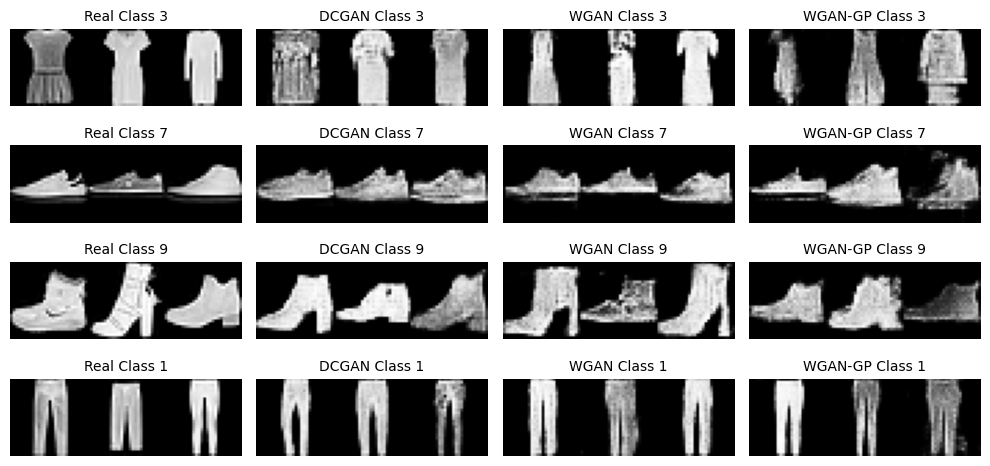

Generated and saved combined image for architecture 0 with specified classes.


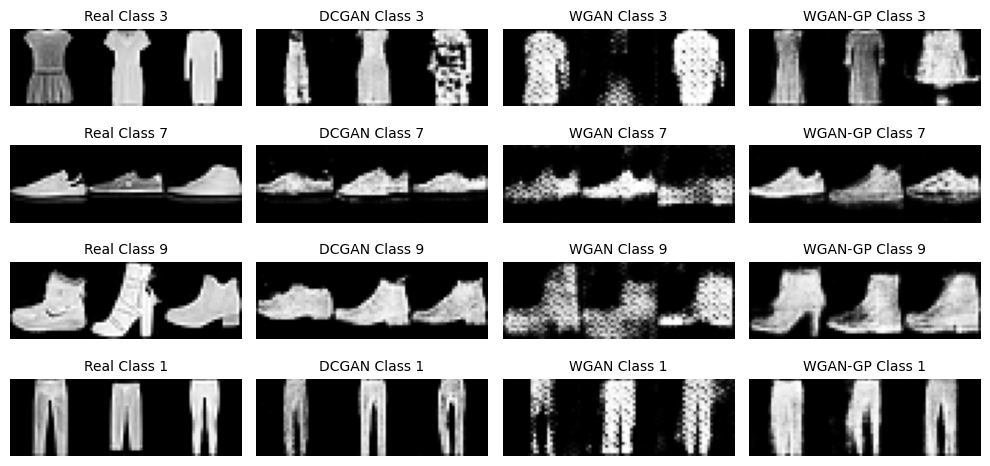

Generated and saved combined image for architecture 1 with specified classes.
All combined images for each architecture and specified classes have been generated and saved.


In [26]:
import torch.nn.functional as F
from torchvision.utils import save_image
import torch.nn.functional as F
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms


# Specify parameters
num_architectures = 2  # Number of architectures (Generator and Discriminator)
generators = [Generator1, Generator2]
discriminators = [Discriminator1, Discriminator2]


# Define your parameters
os.makedirs('samples/final/', exist_ok=True)
target_classes = [3, 7, 9, 1]  # Specify the classes you want to showcase
num_images = 3  # Number of examples per class
modes = ['dcgan', 'wgan', 'wgan-gp']
mode_titles = ['Real', 'DCGAN', 'WGAN', 'WGAN-GP']

# Transformation for displaying images with matplotlib
to_pil = transforms.ToPILImage()


for arch in range(num_architectures):
    fig, axs = plt.subplots(len(target_classes), len(modes) + 1, figsize=(10, 5))  # Adjust layout as needed

    for class_idx, target_class in enumerate(target_classes):
        real_images_class = []

        # Fetch real images for the target class from the dataset
        for real_image, label in dataloader.dataset:
            if label == target_class:
                real_images_class.append(real_image)
            if len(real_images_class) == num_images:
                break
        real_images_class = torch.stack(real_images_class).to(device)

        # Concatenate real images horizontally and remove extra dimension for grayscale
        combined_real_images = torch.cat([real_images_class[i] for i in range(num_images)], dim=2)
        axs[class_idx, 0].imshow(combined_real_images.squeeze().cpu(), cmap='gray')
        axs[class_idx, 0].set_title(f'Real Class {target_class}', fontsize=10)
        axs[class_idx, 0].axis('off')

        # Generate images for each mode and display them
        for mode_idx, mode in enumerate(modes):
            # Load the generator model
            G = generators[arch](noise_dim, num_classes, image_channels, feature_dim, mode).to(device)
            G.load_state_dict(torch.load(f'{mode}_generator_arch_{arch}.pth', weights_only=True))  # Use weights_only=True
            G.eval()

            # Generate noise and one-hot encoded label
            one_hot_label = F.one_hot(torch.tensor([target_class] * num_images), num_classes=num_classes).float().to(device)
            noise = torch.randn(num_images, noise_dim, device=device)

            # Generate the images
            with torch.no_grad():
                generated_images = G(noise, one_hot_label).cpu()

            # Concatenate generated images horizontally and remove extra dimension for grayscale
            combined_generated_images = torch.cat([generated_images[i] for i in range(num_images)], dim=2)

            # Display in the appropriate column
            axs[class_idx, mode_idx + 1].imshow(combined_generated_images.squeeze(), cmap='gray')
            axs[class_idx, mode_idx + 1].set_title(f'{mode.upper()} Class {target_class}', fontsize=10)
            axs[class_idx, mode_idx + 1].axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0)

    # Final layout and save
    plt.tight_layout()
    plt.savefig(f'samples/final/arch{arch}_combined_modes_classes.png', dpi=100)
    plt.show()
    print(f"Generated and saved combined image for architecture {arch} with specified classes.")

print("All combined images for each architecture and specified classes have been generated and saved.")